# Dolsek and Fajfar (2004)

This methodology makes use of work by [Dolsek and Fajfar (2004)](http://onlinelibrary.wiley.com/doi/10.1002/eqe.410/abstract) to estimate the inelastic displacement of a SDOF system based on its elastic displacement and the proposed R−μ−T relationship. Record-to-record dispersion from [Ruiz-García and Miranda (2007)](http://onlinelibrary.wiley.com/doi/10.1002/eqe.680/abstract) can be included in the derivation of fragility curves. It is suitable for single-building fragility curve estimation and is applicable to any kind of multi-linear capacity curves. Individual fragility curves can be later combined into a single fragility curve that considers inter-building uncertainty.

<img src="../../../../../figures/DF_r_mu_T.jpg" width="400" align="middle">

**Note**: To run the code in a cell:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

In [1]:
from rmtk.vulnerability.derivation_fragility.R_mu_T_no_dispersion.dolsek_fajfar import DF2004 
from rmtk.vulnerability.common import utils
%matplotlib inline

---
###Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format described in the [RMTK manual](../../../../../rmtk-docs.pdf). In case multiple capacity curves are input, a spectral shape also needs to be defined.

1. Please provide the location of the file containing the capacity curves using the parameter `capacity_curves_file`.
2. Please also provide a spectral shape using the parameter `input_spectrum` if multiple capacity curves are used.

In [2]:
capacity_curves_file = "../../../../../../rmtk_data/capacity_curves_Vb-dfloor.csv"
input_spectrum = "../../../../../../rmtk_data/FEMAP965spectrum.txt"

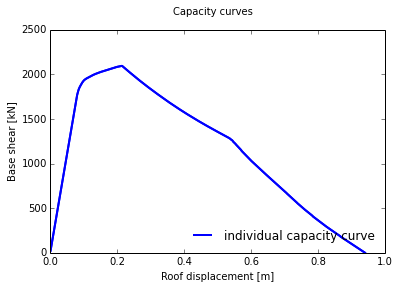

In [3]:
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
Sa_ratios = utils.get_spectral_ratios(capacity_curves, input_spectrum)
utils.plot_capacity_curves(capacity_curves)

###Idealise pushover curves

In order to use this methodology the pushover curves need to be idealised. Please choose an idealised shape using the parameter `idealised_type`. The valid options for this methodology are "bilinear" and "quadrilinear". Idealised curves can also be directly provided as input by setting the field `Idealised` to `TRUE` in the input file defining the capacity curves.

In [4]:
idealised_type = "quadrilinear"

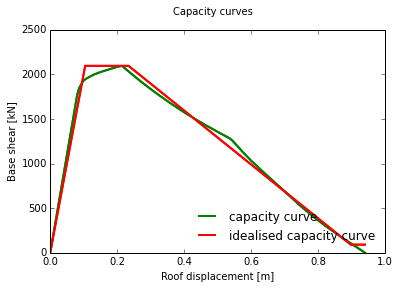

In [5]:
idealised_capacity = utils.idealisation(idealised_type, capacity_curves)
utils.plot_idealised_capacity(idealised_capacity, capacity_curves, idealised_type)

###Load damage state thresholds

Please provide the path to your damage model file using the parameter `damage_model_file` in the cell below.

In [6]:
damage_model_file = "../../../../../../rmtk_data/damage_model_ISD.csv"

In [7]:
damage_model = utils.read_damage_model(damage_model_file)

###Calculate fragility functions

The damage threshold dispersion is calculated and integrated with the record-to-record dispersion through Monte Carlo simulations.
1. Please enter the number of Monte Carlo samples to be performed using the parameter `montecarlo_samples` in the cell below.
2. Please also define the constant acceleration-constant velocity and constant velocity-constant displacement corner periods of a Newmark-Hall type spectrum using the parameter `corner_periods`.

In [8]:
montecarlo_samples = 50
corner_periods = [0.5, 1.8]

In [9]:
fragility_model = DF2004.calculate_fragility(capacity_curves, idealised_capacity, damage_model, montecarlo_samples, Sa_ratios, corner_periods)

mu(LS) =  [ 2.02678158  4.53093238  6.93909052  9.00340945]
medians= [ 0.23898569  0.44567559  0.67287736  0.80718792]
total dispersion= [ 0.31440205  0.35141257  0.38842298  0.39024992]


### Plot fragility functions

The following parameters need to be defined in the cell below in order to plot the lognormal CDF fragility curves obtained above:
* `minIML` and `maxIML`: These parameters define the limits of the intensity measure level for plotting the functions

In [10]:
minIML, maxIML = 0.01, 2.00

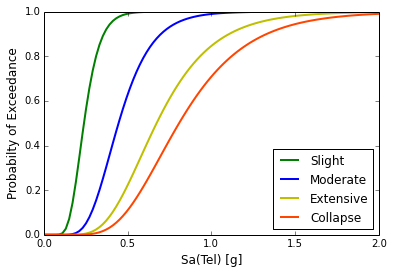

In [11]:
utils.plot_fragility_model(fragility_model, minIML, maxIML)

### Save fragility functions

The derived parametric fragility functions can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
2. `minIML` and `maxIML`: These parameters define the bounds of applicability of the functions.
3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [13]:
taxonomy = "RC"
minIML, maxIML = 0.01, 2.00
output_type = "csv"

In [14]:
utils.save_mean_fragility(taxonomy,fragility_model,minIML,maxIML,output_type)

### Obtain vulnerability function

A vulnerability model can be derived by combining the set of fragility functions obtained above with a consequence model. In this process, the fractions of buildings in each damage state are multiplied by the associated damage ratio from the consequence model, in order to obtain a distribution of loss ratio for each intensity measure level. 

The following parameters need to be defined in the cell below in order to calculate vulnerability functions using the above derived fragility functions:
1. `cons_model_file`: This parameter specifies the path of the consequence model file.
2. `imls`: This parameter specifies a list of intensity measure levels in increasing order at which the distribution of loss ratios are required to be calculated.
3. `distribution_type`: This parameter specifies the type of distribution to be used for calculating the vulnerability function. The distribution types currently supported are "lognormal", "beta", and "PMF".

In [14]:
cons_model_file = "../../../../../../rmtk_data/cons_model.csv"
imls = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 
        0.60, 0.70, 0.80, 0.90, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00]
distribution_type = "lognormal"

In [15]:
cons_model = utils.read_consequence_model(cons_model_file)
vulnerability_model = utils.convert_fragility_vulnerability(fragility_model, cons_model, 
                                                            imls, distribution_type)

### Plot vulnerability function



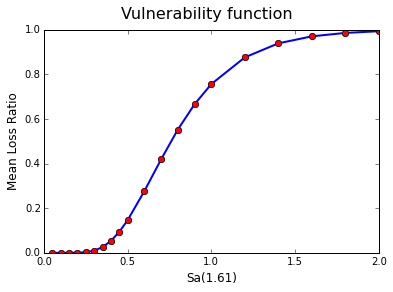

In [16]:
utils.plot_vulnerability_model(vulnerability_model)

### Save vulnerability function

The derived parametric or nonparametric vulnerability function can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [17]:
taxonomy = "RC"
output_type = "nrml"

In [ ]:
utils.save_vulnerability(taxonomy, vulnerability_model, output_type)